Find the best-fit parameters. Find the points within highest density regions through kNN, and find the point with the highest averaged lnprob.

In [1]:
from __future__ import division, print_function
import os, sys, gc
import numpy as np
import matplotlib.pyplot as plt
import fitsio

from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.sim_manager import CachedHaloCatalog

from Corrfunc.theory.wp import wp as cf_wp

np.set_printoptions(precision=3, suppress=True)

import Corrfunc
print(Corrfunc.__version__)

import corner_new1

2.2.0


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
params = {'legend.fontsize':'large',
          'axes.labelsize':'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'figure.facecolor':'w',
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction':'in',
          'ytick.direction':'in',
         } 
plt.rcParams.update(params)

In [4]:
# start from 1
zbin_index = 3

# redshift bins
zbins = [[0.41, 0.5], [0.5, 0.61], [0.61, 0.72], [0.75, 0.83], [0.84, 0.93]]
# MDPL2 scale factors
sim_scale_factors = ['0.68620', '0.64210', '0.60080', '0.56220', '0.53780']

sim_scale_factor = sim_scale_factors[zbin_index-1]
zmin, zmax = zbins[zbin_index-1]
print('{:.2f} < z < {:.2f}'.format(zmin, zmax))

# Minimum number of particles of a halo to host galaxies
num_ptcl_requirement = 300

# pi_max
pi_max = 150

# Pre-computed list of comoving distance errors
cd_errors_file = '/data/roz18/lrg_wprp/dr7/cd_error_{:.3f}_{:.3f}_20190103.fits'.format(zmin, zmax)

0.61 < z < 0.72


__MCMC results__

In [5]:
# redshift bins
zbins = [[0.41, 0.5], [0.5, 0.61], [0.61, 0.72], [0.75, 0.83], [0.84, 0.93]]
sim_scale_factors = ['0.68620', '0.64210', '0.60080', '0.56220', '0.53780']
redshifts = 1/np.array(sim_scale_factors, dtype=float) - 1

mcmc_dir = '/home/roz18/lrg_wprp_hodfit_dr7/'
run_dates = [0]*len(zbins)
nburn_all = [0]*len(zbins)
run_dates[0] = ['run_20190107_bin1', 'run_20190118_bin1', 'run_20190127_bin1']
nburn_all[0] = [3000, 0, 3000]
run_dates[1] = ['run_20190113_bin2', 'run_20190120_bin2', 'run_20190131_bin2']
nburn_all[1] = [5000, 0, 5000]
run_dates[2] = ['run_20190103_bin3', 'run_20190122_bin3', 'run_20190211_bin3']
nburn_all[2] = [4000, 0, 4000]
run_dates[3] = ['run_20190115_bin4', 'run_20190124_bin4', 'run_20190215_bin4']
nburn_all[3] = [2000, 0, 2000]
run_dates[4] = ['run_20190116_bin5', 'run_20190126_bin5', 'run_20190218_bin5', 'run_20190515_bin5']
nburn_all[4] = [5000, 0, 5000, 0]

In [6]:
downsample_factor = 50

In [7]:
samples_stack = []

for index1 in range(len(run_dates[zbin_index-1])):
    nburn = nburn_all[zbin_index-1][index1]
    mcmc_path = os.path.join(mcmc_dir, run_dates[zbin_index-1][index1], 'chains.npy')
    mcmc_result = np.load(mcmc_path)
    # If the MCMC run was manually stopped, the chain would have zeros at the end
    first_zero_index = np.argmax(np.all(mcmc_result[0]==0, axis=1))
    if first_zero_index==0:
        first_zero_index = len(mcmc_result[0])
    mcmc_result = mcmc_result[:, :first_zero_index, :]

    # burn!
    mcmc_result = mcmc_result[:, nburn:, :]

    # subsampling
    mcmc_result_sub = mcmc_result[:, ::downsample_factor]
    # print(mcmc_result.shape)
    # print(mcmc_result_sub.shape)

    # x = np.arange(500)
    # plt.figure(figsize=(15, 4))
    # plt.plot(x, mcmc_result[0, :500, 0], '.', markersize=1)
    # plt.plot(x[::downsample_factor], mcmc_result_sub[0, :len(x[::downsample_factor]), 0], '.', markersize=5)
    # plt.show()
    
    # Swap axis so that the zbin_index-1 is always increasing with time
    mcmc_result_sub = np.swapaxes(mcmc_result_sub, 0, 1)
    # print(mcmc_result_sub.shape)
    # print()
    
    samples_stack.append(np.concatenate(mcmc_result_sub, axis=0))
    
samples = np.concatenate(samples_stack, axis=0)

print('{:.2f} < z < {:.2f}  '.format(zmin, zmax), samples.shape)

0.61 < z < 0.72   (21600, 8)


In [8]:
print('Median values:')
print('   [alpha  logM1  sigma_logM  logM0  logMmin  pzerr_rescale  bias]')
params_median = np.median(samples, axis=0)
params_std = np.std(samples, axis=0)
print('  ', params_median[[0, 1, 2, 3, 4, 5, 7]])
print('+-', params_std[[0, 1, 2, 3, 4, 5, 7]])
print()

# Find the best-fit parameters in segments of the chain
params_1_sigma_range = (np.percentile(samples, 84, axis=0) - np.percentile(samples, 16, axis=0))/2

print('1-sigma range:')
print('   [alpha  logM1  sigma_logM  logM0  logMmin  pzerr_rescale  bias]')
print('  ', params_1_sigma_range[[0, 1, 2, 3, 4, 5, 7]])

Median values:
   [alpha  logM1  sigma_logM  logM0  logMmin  pzerr_rescale  bias]
   [ 1.328 13.921  0.19  11.968 12.854  0.699  2.066]
+- [0.066 0.046 0.12  0.518 0.054 0.072 0.034]

1-sigma range:
   [alpha  logM1  sigma_logM  logM0  logMmin  pzerr_rescale  bias]
   [0.058 0.045 0.132 0.6   0.05  0.075 0.033]


In [9]:
from sklearn.neighbors import NearestNeighbors

data = samples[:, :6]

# Reflect against hard prior boundaries
# sigma_logM
data_new = np.copy(data)
data_new[:, 2] = -data_new[:, 2]
data = np.concatenate([data, data_new], axis=0)
# pzerr_rescale
data_new = np.copy(data)
data_new[:, 5] = 0.6-(data_new[:, 5]-0.6)
data = np.concatenate([data, data_new], axis=0)

# rescaling the dimensions
data_rescale = data/params_1_sigma_range[None, :6]

# Find the distance to the n-th nearest neighbor
neigh = NearestNeighbors(n_neighbors=501, radius=np.inf, algorithm='kd_tree')
neigh.fit(data_rescale)
dist, _ = neigh.kneighbors(data_rescale, return_distance=True)

# Remove the reflected points
maxdist = np.max(dist, axis=1)
idx_best = np.argsort(maxdist)
# mask = (data[:, 2][idx_best]>0) & (data[:, 5][idx_best]>0.6)
mask = idx_best < len(samples)
print(np.sum(mask)/len(idx_best))
idx_best = idx_best[mask]

# select the top n_best points
n_best = 500
idx_best = idx_best[:n_best]

0.25


494


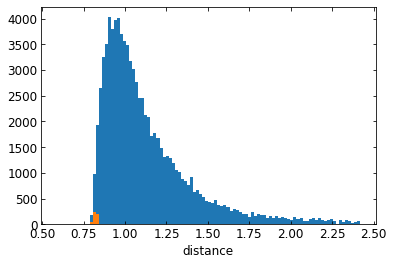

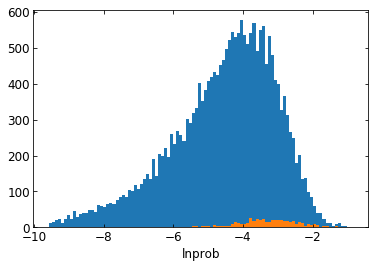

In [10]:
print(len(np.unique((samples[:, 0]*samples[:, 1]*samples[:, 2])[idx_best])))
plt.hist(maxdist, 100, range=(np.min(maxdist)-0.2, np.percentile(maxdist, 99)))
plt.hist(maxdist[idx_best], 100, range=(np.min(maxdist)-0.2, np.percentile(maxdist, 99)))
plt.xlabel('distance')
plt.show()

plt.hist(samples[:, 6], 100, range=(np.percentile(samples[:, 6], 1), samples[:, 6].max()))
plt.hist(samples[:, 6][idx_best], 100, range=(np.percentile(samples[:, 6], 1), samples[:, 6].max()))
plt.xlabel('lnprob')
plt.show()

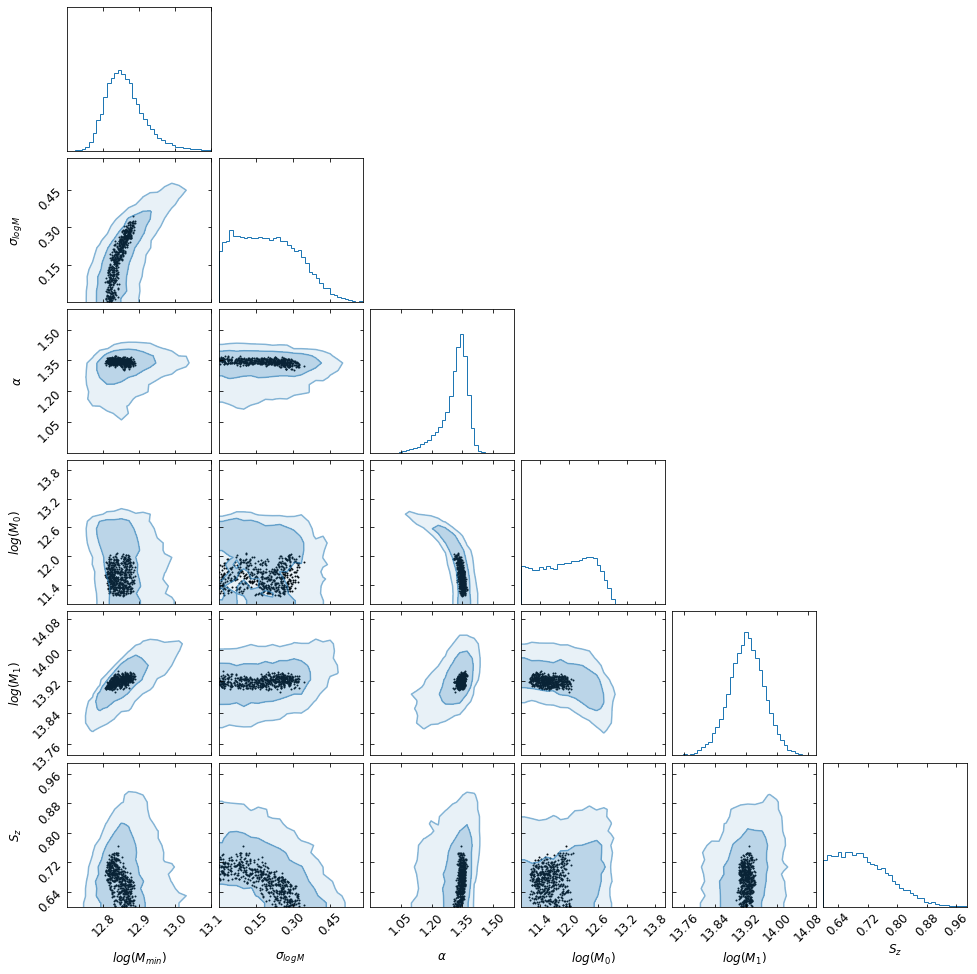

In [11]:
ranges_plot_all = [[[12.7, 13.15], [0,  0.58], [0.45, 1.6], [11, 14], [13.73, 14.18], [0.6, 1.1]],
                   [[12.7, 13.15], [0,  0.58], [0.45, 1.6], [11, 14], [13.73, 14.18], [0.6, 1.1]],
                   [[12.7, 13.1], [0,  0.58], [0.9, 1.6], [11, 14], [13.73, 14.1], [0.6, 0.99]],
                   [[12.7, 13.595], [0,  0.9], [0.7, 1.8], [11, 14], [13.77, 14.5], [0.6, 1.25]],
                   [[12.7, 13.595], [0,  0.9], [0.7, 1.8], [11, 14], [13.77, 14.5], [0.6, 1.25]]]
hist_ylims_all = [[15, 6, 11, 2, 11, 14],
                  [15, 6, 11, 2, 11, 14],
                  [15, 6, 11, 2, 11, 14],
                  [10, 4, 11, 1, 11, 6.5],
                  [10, 4, 11, 1, 11, 6.5]]

ranges_plot = ranges_plot_all[zbin_index-1]
hist_ylims = hist_ylims_all[zbin_index-1]

samples_plot = samples[:, [4, 2, 0, 3, 1, 5]]
fig = corner_new1.corner(samples_plot, labels=[r"$log(M_{min})$",  r"$\sigma_{log\, M}$", r"$\alpha$", r"$log(M_0)$", r"$log(M_1)$", r"$S_z$"],
              levels=(0.68, 0.95,), plot_datapoints=False, fill_contours=True, plot_density=False, color='C0',
              range=ranges_plot, bins1d=40, bins2d=20, hist_ylims=hist_ylims)
samples_plot_best = samples_plot[idx_best]
fig = corner_new1.corner_scatter(samples_plot_best, labels=[r"$log(M_{min})$",  r"$\sigma_{log\, M}$", r"$\alpha$", r"$log(M_0)$", r"$log(M_1)$", r"$S_z$"],
             plot_datapoints=True, fill_contours=False, plot_density=False, color='C0',
              range=ranges_plot, bins1d=40, bins2d=20, hist_ylims=hist_ylims, fig=fig)
plt.show()

__Compute the averaged lnprob__

In [12]:
# Comoving distance errors from photo-z errors
print(cd_errors_file)
cd_errors_table = fitsio.read(cd_errors_file)
cd_errors = np.array(cd_errors_table['cd_error'])

# Load halo catalog
halocatalog = CachedHaloCatalog(fname='/data/roz18/MDPL2_Rockstar/hlist_{}_minptclnum_100.hdf5'.format(sim_scale_factor))
nhalo = len(halocatalog.halo_table)
print(nhalo)

############################################################################################

# MCMC data file
data_dir = os.path.join('/home/roz18/lrg_wprp_hodfit_dr7/mcmc_inputs/', 'z_{:.2f}_{:.2f}'.format(zmin, zmax))
binfile_mcmc = os.path.join(data_dir, 'rp_binedges.dat')
binfile_full = os.path.join(data_dir, 'rp_binedges_full_range.dat')

rpbinedges = np.unique(np.loadtxt(binfile_mcmc))
rpbinctr_mcmc = (rpbinedges[1:]+rpbinedges[:-1])/2
rpbinedges = np.unique(np.loadtxt(binfile_full))
rpbinctr_full = (rpbinedges[1:]+rpbinedges[:-1])/2

############################################################################################

sim_redshift = 1/float(sim_scale_factor) - 1
print('Simulation redshift = ', sim_redshift)

default_hod_model_name='zheng07'
hod_model = PrebuiltHodModelFactory(default_hod_model_name)
hod_model.redshift = sim_redshift

############################################################################################

obs = {}
col1, col2, col3 = np.loadtxt('/home/roz18/lrg_wprp_hodfit_dr7/mcmc_inputs/z_{0:.2f}_{1:.2f}/wp_{0:.2f}_{1:.2f}.dat'.format(zmin, zmax), unpack=True)
obs['ngal'], obs['ngalerr'] = col2[0], col3[0]
obs['rp'], obs['wp'], obs['wperr'] = col1[1:], col2[1:], col3[1:]
obs['covar'] = np.loadtxt('/home/roz18/lrg_wprp_hodfit_dr7/mcmc_inputs/z_{0:.2f}_{1:.2f}/wp_cov_{0:.2f}_{1:.2f}.dat'.format(zmin, zmax), unpack=True)
obs['cov_inv'] = np.linalg.inv(obs['covar'])

/data/roz18/lrg_wprp/dr7/cd_error_0.610_0.720_20190103.fits
22296922
Simulation redshift =  0.6644474034620507


In [ ]:
import time

nthreads = 4

# number of repeats
nrepeat = 100

lnlike_all = np.zeros((len(idx_best), nrepeat))

time_last = time.time()
for index in range(len(idx_best)):
    
    hod_model.param_dict['alpha'] = samples[idx_best[index]][0]
    hod_model.param_dict['logM1'] = samples[idx_best[index]][1]
    hod_model.param_dict['sigma_logM'] = samples[idx_best[index]][2]
    hod_model.param_dict['logM0'] = samples[idx_best[index]][3]
    hod_model.param_dict['logMmin'] = samples[idx_best[index]][4]
    pzerr_rescale = samples[idx_best[index]][5]

    # Repeatedly populate galaxies and average lnL
    for repeat_index in range(nrepeat):

        try:
            hod_model.mock.populate()
            gc.collect()
        except AttributeError:
            hod_model.populate_mock(halocatalog, Num_ptcl_requirement=num_ptcl_requirement)

        number_gal = len(hod_model.mock.galaxy_table)
        
        cd_errors_draw = pzerr_rescale * np.random.choice(cd_errors, size=len(hod_model.mock.galaxy_table), replace=True)
        zdist = (hod_model.mock.galaxy_table['z'] + cd_errors_draw) % hod_model.mock.Lbox[0]
        
        cf_results = cf_wp(hod_model.mock.Lbox[0],
            pi_max,
            nthreads,
            binfile_mcmc,
            np.array(hod_model.mock.galaxy_table['x'], dtype=np.float32),
            np.array(hod_model.mock.galaxy_table['y'], dtype=np.float32),
            np.array(zdist, dtype=np.float32))
        model_wp = cf_results['wp']

        # log likelihood from wprp
         
        #####################################################################
    
    time_now = time.time()
    print('{}  {:.0f} sec'.format(index, time_now-time_last))
    time_last = time_now

np.savez_compressed('data/best_fit_lnprob_zbin_{}.npz'.format(zbin_index), 
                    idx=idx_best, lnlike_all=lnlike_all)

0  356 sec
1  334 sec


--------

In [23]:
results = np.load('data/best_fit_lnprob_zbin_{}.npz'.format(zbin_index))
lnlike_all = results['lnlike_all']

In [24]:
def hlmean(data, multiplier=None, verbose=True):
    ndata = len(data)
    if ndata==0 and verbose:
        print('H-L mean: empty array!!!')
    if ndata < 200:
        pairmean = np.zeros(int(ndata*(ndata+1)/2))
        index = 0
        for i in range(ndata):
            for j in range(i,ndata):
                pairmean[index] = (data[i]+data[j])/2
                index += 1
    else:
        if multiplier==None:
            nsamp = 200 * ndata
        else:
            nsamp = multiplier * ndata
        idx = np.floor(np.random.rand(nsamp,2)*ndata)
        idx = idx.astype(np.int64,copy=False)
        pairmean = np.sum(data[idx],axis=1)/2.
    return(np.median(pairmean))

In [25]:
lnlike_hlmean = np.array([hlmean(lnlike_all[index]) for index in range(len(lnlike_all))])
lnlike_mean = np.mean(lnlike_all, axis=1)
print(np.argsort(lnlike_hlmean)[-1])
print(np.argsort(lnlike_mean)[-1])
print()

idx_single_best = idx_best[np.argsort(lnlike_hlmean)[-1]]
print(idx_single_best)

190
190

13125


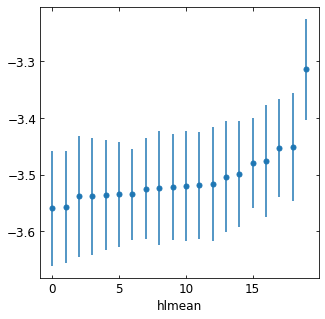

In [32]:
plt.figure(figsize=(5, 5))
plt.errorbar(np.arange(20), lnlike_hlmean[np.argsort(lnlike_hlmean)[-20:]], 
             yerr=np.std(lnlike_all[np.argsort(lnlike_hlmean)[-20:]], axis=1)/np.sqrt(nrepeat), 
             markersize=10, fmt='x', marker='.')
plt.xlabel('hlmean')
# plt.ylabel('mean')
plt.show()

In [27]:
# plt.figure(figsize=(5, 5))
# plt.plot(lnlike_hlmean, lnlike_mean, '.', markersize=2)
# plt.plot(np.linspace(-4, -2), np.linspace(-4, -2))
# plt.axis([-4, -2, -4, -2])
# plt.xlabel('hlmean')
# plt.ylabel('mean')
# plt.show()

# print(np.std(lnlike_all[np.argsort(lnlike_hlmean)[-1]])/np.sqrt(100))
# plt.hist(lnlike_all[np.argsort(lnlike_hlmean)[-1]], 20);

In [28]:
params_best = samples[idx_single_best]
params_best_plus = np.percentile(samples, 84, axis=0) - params_best
params_best_minus = params_best - np.percentile(samples, 16, axis=0)
print('Best-fit values:')
print('  [alpha  logM1  sigma_logM  logM0  logMmin  pzerr_rescale  bias]')
print('  ', params_best[[0, 1, 2, 3, 4, 5, 7]])
print(' +', params_best_plus[[0, 1, 2, 3, 4, 5, 7]])
print(' -', params_best_minus[[0, 1, 2, 3, 4, 5, 7]])

Best-fit values:
  [alpha  logM1  sigma_logM  logM0  logMmin  pzerr_rescale  bias]
   [ 1.319 13.911  0.284 11.958 12.859  0.642  2.037]
 + [0.048 0.055 0.043 0.562 0.053 0.143 0.066]
 - [0.069 0.035 0.221 0.639 0.048 0.008 0.001]


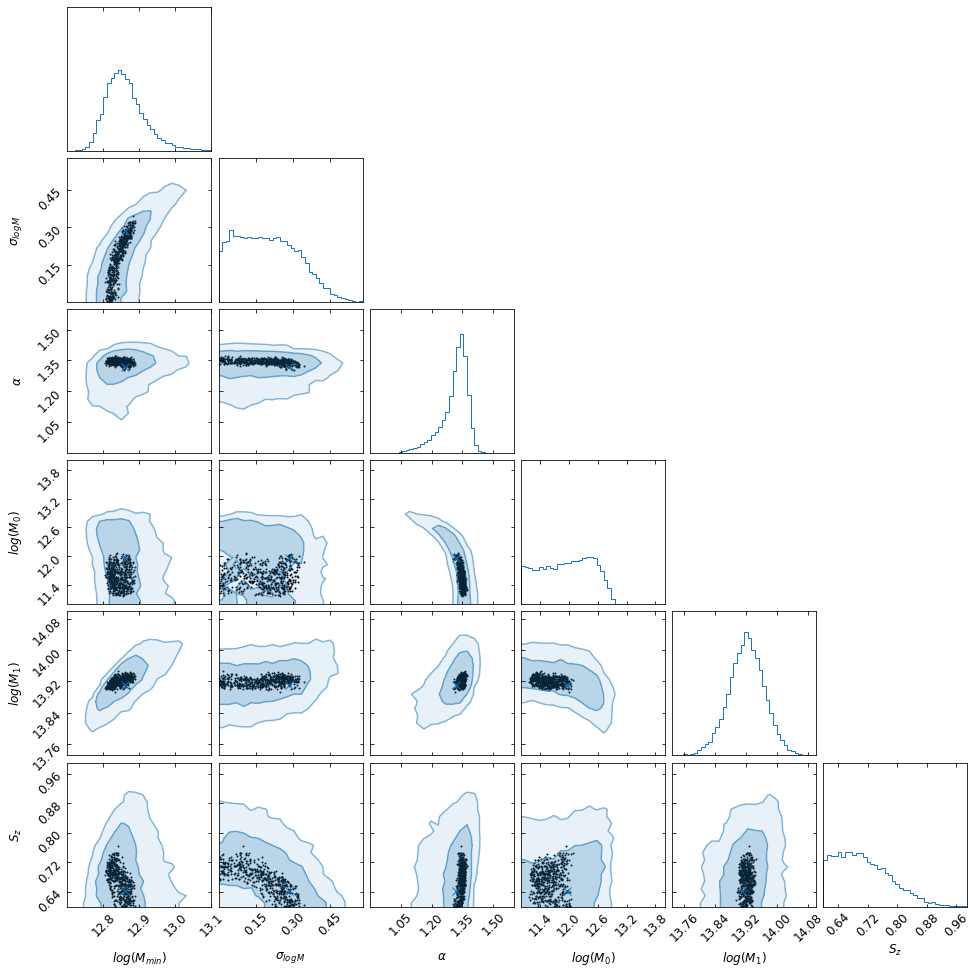

In [29]:
samples_plot = samples[:, [4, 2, 0, 3, 1, 5]]
fig = corner_new1.corner(samples_plot, labels=[r"$log(M_{min})$",  r"$\sigma_{log\, M}$", r"$\alpha$", r"$log(M_0)$", r"$log(M_1)$", r"$S_z$"],
              levels=(0.68, 0.95,), plot_datapoints=False, fill_contours=True, plot_density=False, color='C0',
              range=ranges_plot, bins1d=40, bins2d=20, hist_ylims=hist_ylims, truths=samples[idx_single_best][[4, 2, 0, 3, 1, 5]])
samples_plot_best = samples_plot[idx_best]
fig = corner_new1.corner_scatter(samples_plot_best, labels=[r"$log(M_{min})$",  r"$\sigma_{log\, M}$", r"$\alpha$", r"$log(M_0)$", r"$log(M_1)$", r"$S_z$"],
             plot_datapoints=True, fill_contours=False, plot_density=False, color='C0',
              range=ranges_plot, bins1d=40, bins2d=20, hist_ylims=hist_ylims, fig=fig)
plt.show()

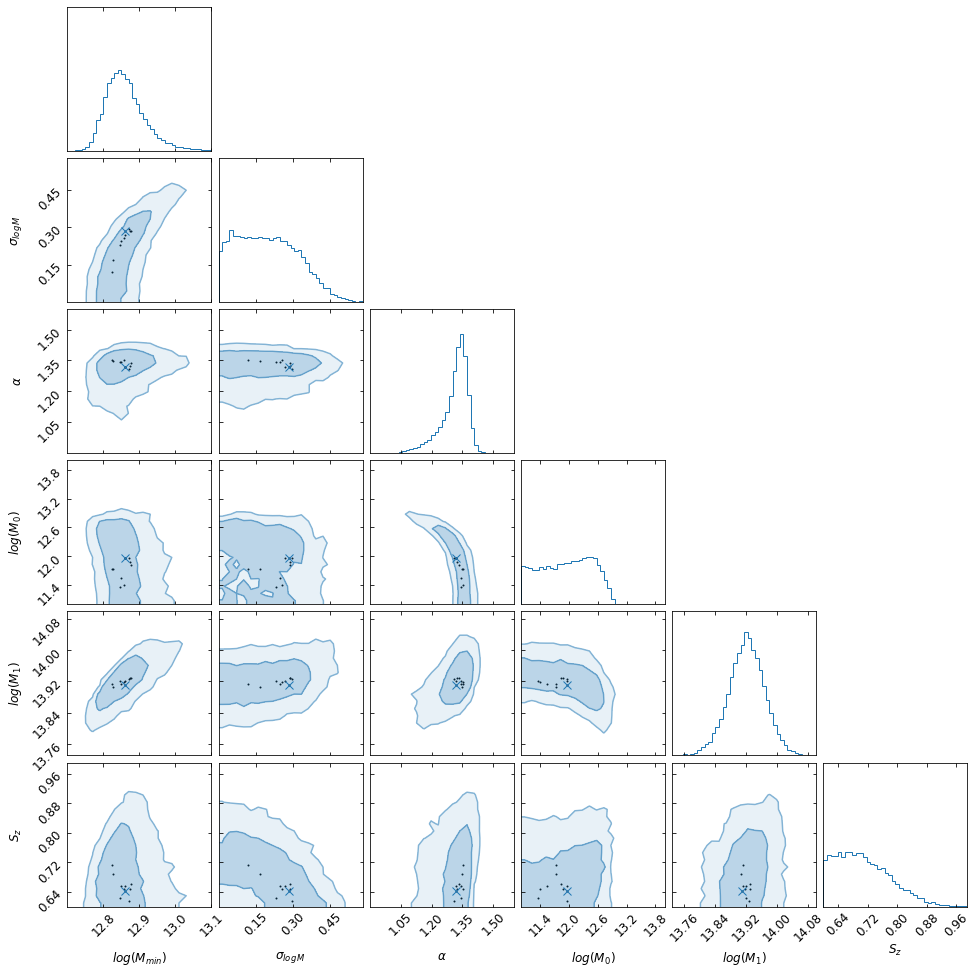

In [38]:
# Top 10 points
idx_best_10 = idx_best[np.argsort(lnlike_hlmean)[-10:]]

samples_plot = samples[:, [4, 2, 0, 3, 1, 5]]
fig = corner_new1.corner(samples_plot, labels=[r"$log(M_{min})$",  r"$\sigma_{log\, M}$", r"$\alpha$", r"$log(M_0)$", r"$log(M_1)$", r"$S_z$"],
              levels=(0.68, 0.95,), plot_datapoints=False, fill_contours=True, plot_density=False, color='C0',
              range=ranges_plot, bins1d=40, bins2d=20, hist_ylims=hist_ylims, truths=samples[idx_single_best][[4, 2, 0, 3, 1, 5]])
samples_plot_best = samples_plot[idx_best_10]
fig = corner_new1.corner_scatter(samples_plot_best, labels=[r"$log(M_{min})$",  r"$\sigma_{log\, M}$", r"$\alpha$", r"$log(M_0)$", r"$log(M_1)$", r"$S_z$"],
             plot_datapoints=True, fill_contours=False, plot_density=False, color='C0',
              range=ranges_plot, bins1d=40, bins2d=20, hist_ylims=hist_ylims, fig=fig)
plt.show()

__Rerun for top-10 points with more repeats__

In [ ]:
import time

nthreads = 4

# number of repeats
nrepeat = 1000

lnlike_all = np.zeros((len(idx_best_10), nrepeat))

time_last = time.time()
for index in range(len(idx_best_10)):
    
    hod_model.param_dict['alpha'] = samples[idx_best_10[index]][0]
    hod_model.param_dict['logM1'] = samples[idx_best_10[index]][1]
    hod_model.param_dict['sigma_logM'] = samples[idx_best_10[index]][2]
    hod_model.param_dict['logM0'] = samples[idx_best_10[index]][3]
    hod_model.param_dict['logMmin'] = samples[idx_best_10[index]][4]
    pzerr_rescale = samples[idx_best_10[index]][5]

    # Repeatedly populate galaxies and average lnL
    for repeat_index in range(nrepeat):

        try:
            hod_model.mock.populate()
            gc.collect()
        except AttributeError:
            hod_model.populate_mock(halocatalog, Num_ptcl_requirement=num_ptcl_requirement)

        number_gal = len(hod_model.mock.galaxy_table)
        
        cd_errors_draw = pzerr_rescale * np.random.choice(cd_errors, size=len(hod_model.mock.galaxy_table), replace=True)
        zdist = (hod_model.mock.galaxy_table['z'] + cd_errors_draw) % hod_model.mock.Lbox[0]
        
        cf_results = cf_wp(hod_model.mock.Lbox[0],
            pi_max,
            nthreads,
            binfile_mcmc,
            np.array(hod_model.mock.galaxy_table['x'], dtype=np.float32),
            np.array(hod_model.mock.galaxy_table['y'], dtype=np.float32),
            np.array(zdist, dtype=np.float32))
        model_wp = cf_results['wp']

        # log likelihood from wprp
        wp_dev = model_wp - obs['wp']
        wplike = -0.5*np.dot(np.dot(wp_dev, obs['cov_inv']), wp_dev)

        # log likelihood from number density
        ngal = number_gal/(hod_model.mock.Lbox[0]**3)
        ng_theory_error = ngal/np.sqrt(number_gal)
        nglike = -0.5*((ngal-obs['ngal'])**2/(obs['ngalerr']**2+ng_theory_error**2))

        lnlike_all[index, repeat_index] = (wplike + nglike)

        #####################################################################
    
    time_now = time.time()
    print('{}  {:.0f} sec'.format(index, time_now-time_last))
    time_last = time_now

np.savez_compressed('data/top10_best_fit_lnprob_zbin_{}.npz'.format(zbin_index), 
                    idx=idx_best_10, lnlike_all=lnlike_all)

0  3538 sec


9
9

13125


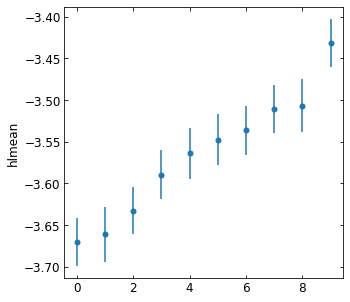

In [48]:
results = np.load('data/top10_best_fit_lnprob_zbin_{}.npz'.format(zbin_index))
lnlike_all = results['lnlike_all']

np.random.seed(53)
lnlike_hlmean = np.array([hlmean(lnlike_all[index], multiplier=50000) for index in range(len(lnlike_all))])
lnlike_mean = np.mean(lnlike_all, axis=1)
print(np.argsort(lnlike_hlmean)[-1])
print(np.argsort(lnlike_mean)[-1])
print()

idx_single_best = idx_best_10[np.argsort(lnlike_hlmean)[-1]]
print(idx_single_best)

plt.figure(figsize=(5, 5))
plt.errorbar(np.arange(len(lnlike_hlmean)), lnlike_hlmean[np.argsort(lnlike_hlmean)], 
             yerr=np.std(lnlike_all[np.argsort(lnlike_hlmean)], axis=1)/np.sqrt(nrepeat), 
             markersize=10, fmt='x', marker='.')
# plt.xlabel('mean')
plt.ylabel('hlmean')
plt.show()

In [45]:
params_best = samples[idx_single_best]
params_best_plus = np.percentile(samples, 84, axis=0) - params_best
params_best_minus = params_best - np.percentile(samples, 16, axis=0)
print('Best-fit values:')
print('  [alpha  logM1  sigma_logM  logM0  logMmin  pzerr_rescale  bias]')
print('  ', params_best[[0, 1, 2, 3, 4, 5, 7]])
print(' +', params_best_plus[[0, 1, 2, 3, 4, 5, 7]])
print(' -', params_best_minus[[0, 1, 2, 3, 4, 5, 7]])

Best-fit values:
  [alpha  logM1  sigma_logM  logM0  logMmin  pzerr_rescale  bias]
   [ 1.319 13.911  0.284 11.958 12.859  0.642  2.037]
 + [0.048 0.055 0.043 0.562 0.053 0.143 0.066]
 - [0.069 0.035 0.221 0.639 0.048 0.008 0.001]


---------
## Save best-fit reconstruction results

In [46]:
mvir_bins = np.linspace(11., 16.0, 100)
mvir_dist_all_halo, _ = np.histogram(np.log10(halocatalog.halo_table['halo_mvir']), bins=mvir_bins)

# number of repeats
nrepeat = 100

# Initialize arrays
lnlike_all = np.zeros((1, nrepeat))
model_wp_all = np.zeros((1, nrepeat, len(rpbinctr_full)))
model_wp_intrinsic_all = np.zeros((1, nrepeat, len(rpbinctr_full)))

mvir_dist_cent_all = np.zeros((1, nrepeat, len(mvir_bins)-1))
mvir_dist_sat_all = np.zeros((1, nrepeat, len(mvir_bins)-1))
number_gal_all = np.zeros((1, nrepeat))

In [47]:
nthreads = 4

for index in [0]:
    
    print(index)
    
    # hod_model.param_dict['alpha'] = samples[idx_select[index]][0]
    # hod_model.param_dict['logM1'] = samples[idx_select[index]][1]
    # hod_model.param_dict['sigma_logM'] = samples[idx_select[index]][2]
    # hod_model.param_dict['logM0'] = samples[idx_select[index]][3]
    # hod_model.param_dict['logMmin'] = samples[idx_select[index]][4]
    # pzerr_rescale = samples[idx_select[index]][5]

    hod_model.param_dict['alpha'] = params_best[0]
    hod_model.param_dict['logM1'] = params_best[1]
    hod_model.param_dict['sigma_logM'] = params_best[2]
    hod_model.param_dict['logM0'] = params_best[3]
    hod_model.param_dict['logMmin'] = params_best[4]
    pzerr_rescale = params_best[5]

    # Repeatedly populate galaxies and average lnL
    for repeat_index in range(nrepeat):

        try:
            hod_model.mock.populate()
            gc.collect()
        except AttributeError:
            hod_model.populate_mock(halocatalog, Num_ptcl_requirement=num_ptcl_requirement)

        number_gal_all[index, repeat_index] = len(hod_model.mock.galaxy_table)
        
        mask = hod_model.mock.galaxy_table['gal_type']=='centrals'
        mvir_dist_cent_all[index, repeat_index], _ = np.histogram(np.log10(hod_model.mock.galaxy_table['halo_mvir'][mask]), bins=mvir_bins)
        mask = hod_model.mock.galaxy_table['gal_type']=='satellites'
        mvir_dist_sat_all[index, repeat_index], _ = np.histogram(np.log10(hod_model.mock.galaxy_table['halo_mvir'][mask]), bins=mvir_bins)
        
        cd_errors_draw = pzerr_rescale * np.random.choice(cd_errors, size=len(hod_model.mock.galaxy_table), replace=True)
        zdist = (hod_model.mock.galaxy_table['z'] + cd_errors_draw) % hod_model.mock.Lbox[0]
        
        # model wprp
        cf_results = cf_wp(hod_model.mock.Lbox[0],
            pi_max,
            nthreads,
            binfile_full,
            np.array(hod_model.mock.galaxy_table['x'], dtype=np.float32),
            np.array(hod_model.mock.galaxy_table['y'], dtype=np.float32),
            np.array(zdist, dtype=np.float32))
        model_wp_all[index, repeat_index] = np.copy(cf_results['wp'])
        
        # intrinsic wprp
        cf_results = cf_wp(hod_model.mock.Lbox[0],
            pi_max,
            nthreads,
            binfile_full,
            np.array(hod_model.mock.galaxy_table['x'], dtype=np.float32),
            np.array(hod_model.mock.galaxy_table['y'], dtype=np.float32),
            np.array(hod_model.mock.galaxy_table['z'], dtype=np.float32))
        model_wp_intrinsic_all[index, repeat_index] = np.copy(cf_results['wp'])

        ######################## Compute lnprob ########################
        number_gal = len(hod_model.mock.galaxy_table)
        
        cf_results = cf_wp(hod_model.mock.Lbox[0],
            pi_max,
            nthreads,
            binfile_mcmc,
            np.array(hod_model.mock.galaxy_table['x'], dtype=np.float32),
            np.array(hod_model.mock.galaxy_table['y'], dtype=np.float32),
            np.array(zdist, dtype=np.float32))
        model_wp = cf_results['wp']

        # log likelihood from wprp
        wp_dev = model_wp - obs['wp']
        wplike = -0.5*np.dot(np.dot(wp_dev, obs['cov_inv']), wp_dev)

        # log likelihood from number density
        ngal = number_gal/(hod_model.mock.Lbox[0]**3)
        ng_theory_error = ngal/np.sqrt(number_gal)
        nglike = -0.5*((ngal-obs['ngal'])**2/(obs['ngalerr']**2+ng_theory_error**2))

        lnlike_all[index, repeat_index] = (wplike + nglike)
        
# Save results
np.savez_compressed('data/single_best_mock_results_zbin_{}.npz'.format(zbin_index), 
                    lnlike_all=lnlike_all, rpbinedges=rpbinedges, model_wp_all=model_wp_all,
                    model_wp_intrinsic_all=model_wp_intrinsic_all, mvir_bins=mvir_bins,
                    mvir_dist_cent_all=mvir_dist_cent_all, mvir_dist_sat_all=mvir_dist_sat_all,
                    mvir_dist_all_halo=mvir_dist_all_halo, number_gal_all=number_gal_all)

0


In [51]:
results = np.load('data/single_best_mock_results_zbin_{}.npz'.format(zbin_index))
lnlike_all = results['lnlike_all']

print(hlmean(lnlike_all[0]))

-3.6201350138983495
